# 50.039 Deep Learning
### Group 19 - Inertial-Based Real-Time Human Action Recognition For Physiotherapy

Human kinetic analysis through automated interpretation of movement data has grown as an important application of deep learning. Models trained on data from wearable sensors and other modalities have shown potential for gaining meaningful insights into human biomechanics, activities, and performance over time. Deep learning has demonstrated potential in applications such as motion capture, action recognition and rehabilitation monitoring.

In this project, we sought to develop a physical therapy exercise classifier using inertial sensor data from the PHYTMO (PHYsical Therapy MOnitoring) dataset [1], which contains inertial measurement unit (IMU) sensor recordings of common physical therapy exercises .

## Imports

In [1]:
import os
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader

from src.tcn import TCN
from src.Dataset import CustomDataset
from src.create_dataset import generate_datasets
from src.TrainHelpers import train_model, plot_loss_graph, encode_data, train_svm, train_TCN, test_TCN
from src.TestHelpers import test_model, calculate_accuracy

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps") 
else:
    device = torch.device("cpu")
print(device)

cuda


In [3]:
seed = 369

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Download and Extract Raw Data

If this repo was cloned from Github, the dataset should already be cloned, and the next two steps are not necessary.

If not, the full dataset can be downloaded from the following URL: https://zenodo.org/records/6319979/files/PHYTMO.zip?download=1

Please unzip the folder contents into the provided 'input' folder, as shown:

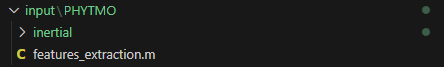

Else, replace the path in the cell below with the path of the extracted data.

In [4]:
RAW_DATASET_DIR = os.path.join(".", "input", "PHYTMO")

## Preprocess and Generate Dataset

The following function is imported from src/create_datasets.py. Its function is to extract only the data we want to use from the Raw Dataset, as well as preprocess it with the following operations:

1. Trimming to remove 'Dead' data at the start and end of each file
2. Downsampling to 20Hz
3. Min-Max Scaling
4. 'Windowed' into 3 second segments at intervals of 0.5 seconds
5. Split into Train, Test and Val sets in a 7:2:1 Ratio

The generated files will be stored in the 'input' folder. 

In [5]:
generate_datasets(RAW_DATASET_DIR)

## Load and Check Data

(11578, 60, 9) (3308, 60, 9) (1654, 60, 9)


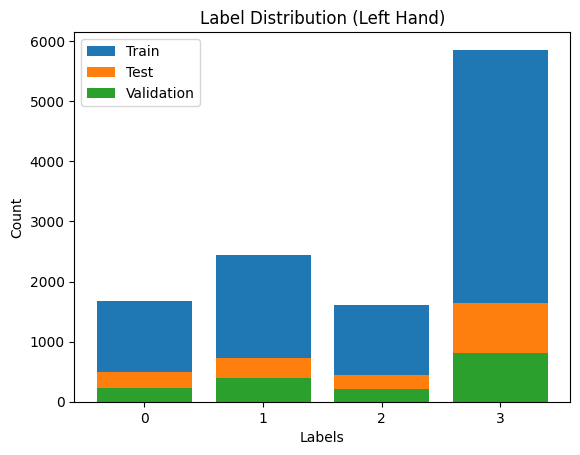

In [5]:
dataset_ver = '3w05s_Larm'

# Load Data
x_train_L = np.load(f'input/train_data_{dataset_ver}.npy')
x_val_L = np.load(f'input/val_data_{dataset_ver}.npy')
x_test_L = np.load(f'input/test_data_{dataset_ver}.npy')

y_train_L = np.load(f'input/train_labels_{dataset_ver}.npy')
y_val_L = np.load(f'input/val_labels_{dataset_ver}.npy')
y_test_L = np.load(f'input/test_labels_{dataset_ver}.npy')

# Create Datasets and Dataloaders
train_dataset_L = CustomDataset("train", dataset_ver)
train_dataloader_L = DataLoader(train_dataset_L, batch_size=16, shuffle=True)
val_dataset_L = CustomDataset("val", dataset_ver)
val_dataloader_L = DataLoader(val_dataset_L, batch_size=16, shuffle=True)
test_dataset_L = CustomDataset("test", dataset_ver)
test_dataloader_L = DataLoader(test_dataset_L, batch_size=16, shuffle=True)

# Check Dataset
print(x_train_L.shape, x_test_L.shape, x_val_L.shape)
unique_labels_train, label_counts_train = np.unique(y_train_L, return_counts=True)
unique_labels_val, label_counts_val = np.unique(y_val_L, return_counts=True)
unique_labels_test, label_counts_test = np.unique(y_test_L, return_counts=True)

plt.bar(unique_labels_train, label_counts_train, label='Train')
plt.bar(unique_labels_test, label_counts_test, label='Test')
plt.bar(unique_labels_val, label_counts_val, label='Validation')

# Set the x-axis tick labels
plt.xticks(unique_labels_train, unique_labels_train)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution (Left Hand)')
plt.legend()
plt.show()

(11582, 60, 9) (3310, 60, 9) (1655, 60, 9)


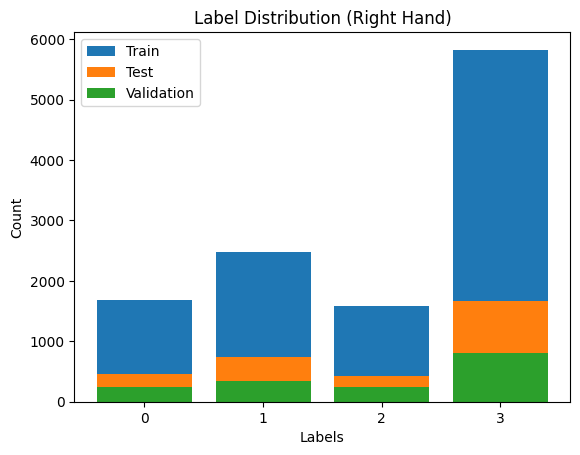

In [6]:
dataset_ver = '3w05s_Rarm'

# Load Data
x_train_R = np.load(f'input/train_data_{dataset_ver}.npy')
x_val_R = np.load(f'input/val_data_{dataset_ver}.npy')
x_test_R = np.load(f'input/test_data_{dataset_ver}.npy')

y_train_R = np.load(f'input/train_labels_{dataset_ver}.npy')
y_val_R = np.load(f'input/val_labels_{dataset_ver}.npy')
y_test_R = np.load(f'input/test_labels_{dataset_ver}.npy')

# Create Datasets and Dataloaders
train_dataset_R = CustomDataset("train", dataset_ver)
train_dataloader_R = DataLoader(train_dataset_R, batch_size=16, shuffle=True)
val_dataset_R = CustomDataset("val", dataset_ver)
val_dataloader_R = DataLoader(val_dataset_R, batch_size=16, shuffle=True)
test_dataset_R = CustomDataset("test", dataset_ver)
test_dataloader_R = DataLoader(test_dataset_R, batch_size=16, shuffle=True)

# Check Dataset
print(x_train_R.shape, x_test_R.shape, x_val_R.shape)
unique_labels_train, label_counts_train = np.unique(y_train_R, return_counts=True)
unique_labels_val, label_counts_val = np.unique(y_val_R, return_counts=True)
unique_labels_test, label_counts_test = np.unique(y_test_R, return_counts=True)

plt.bar(unique_labels_train, label_counts_train, label='Train')
plt.bar(unique_labels_test, label_counts_test, label='Test')
plt.bar(unique_labels_val, label_counts_val, label='Validation')

# Set the x-axis tick labels
plt.xticks(unique_labels_train, unique_labels_train)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution (Right Hand)')
plt.legend()
plt.show()

## Solution

The following contains code for our best performing model, as well as the code to train it. The model weights are also available for direct loading if preferred. All other model variations for testing are included in notebooks/training.

### Model

Our best performing model is first training a CNN-LSTM Autoencoder with 1 CNN Layer followed by 1 LSTM Layer. The CNN layer uses 64 3-by-3 kernels with a padding of 1. The LSTM Layer is a unidirectional LSTM with a hidden size of 360. Finally, a dropout layer is included with a ratio of 0.2.

In [8]:
# 1- Layer CNN + 1-Layer Unidirectional LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(Encoder, self).__init__()
        nb_filters = 64
        self.conv = nn.Conv1d(input_size, nb_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.LSTM1 = nn.LSTM(nb_filters, hidden_size, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_size = hidden_size

    def forward(self, x):
        x = x.permute(0, 2, 1)  # conv = (batch, no of channels, sequence length)
        x = self.conv(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # swap back
        x, (encoded_x, _) = self.LSTM1(x)
        x = self.dropout(encoded_x)
        return x[-1,:,:]

class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_rate):
        super(Decoder, self).__init__()
        nb_filters = 64
        self.hidden_size = hidden_size
        self.conv = nn.Conv1d(hidden_size, nb_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.LSTM1 = nn.LSTM(nb_filters, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.output = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, 60, 1)
        x = x.permute(0, 2, 1)  # conv = (batch, no of channels, sequence length)
        x = self.conv(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # swap back
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x = self.output(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size, dropout_rate).to(device)
        self.decoder = Decoder(hidden_size, in_out_size, dropout_rate).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Training

Two models are trained for ease of use at inference time: Each IMU can stream data to its own model for prediction. For demonstration purposes in this notebook, and in the interest of time, the Right Hand model is omitted.

In [9]:
n_input = 9
n_hidden = 360
num_epochs = 50
dropout_rate = 0.2
lr_rate = 1e-3
early_stop = 5

encoder_ver = f'{n_hidden}h{num_epochs}e{dropout_rate}dr{lr_rate}lr'

The code in the following cell can be omitted if you do not wish to retrain the model.

In [10]:
# # Model for Left Hand
# tag = '1CNN_1LSTM_UD_Larm'

# # Train and save Autoencoder
# train_losses, val_losses = train_model(Autoencoder, train_dataloader_L, val_dataloader_L, val_dataset_L, n_input, n_hidden, dataset_ver, encoder_ver, tag, early_stop, dropout_rate, num_epochs, lr_rate)
# plot_loss_graph(train_losses, val_losses, tag)

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.9632987910189983


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 96.95%


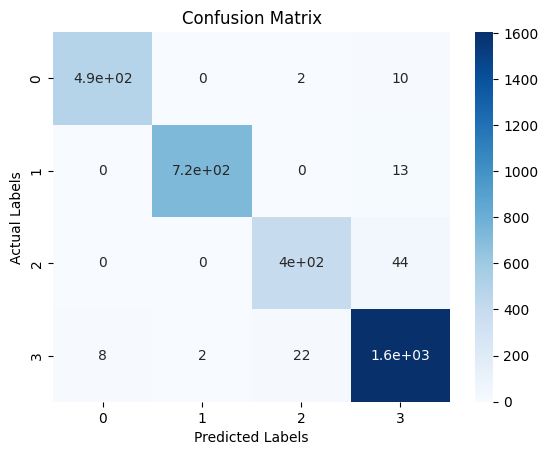

In [11]:
tag = '1CNN_1LSTM_UD_Larm'

# Load Encoder, Encode data
encoded_data, labels = encode_data(train_dataloader_L, dataset_ver, tag, encoder_ver)

# Train SVM
svm_classifier = train_svm(encoded_data, labels.ravel(), dataset_ver, tag, encoder_ver)
test_labels, test_predictions = test_model(test_dataloader_L, dataset_ver, tag, encoder_ver)
calculate_accuracy(test_labels, test_predictions, tag)

In [12]:
# Model for Right Hand
# tag = '1CNN_1LSTM_UD_Rarm'

# # Train and save Autoencoder
# train_losses, val_losses = train_model(Autoencoder, train_dataloader_R, val_dataloader_R, val_dataset_R, n_input, n_hidden, dataset_ver, encoder_ver, tag, early_stop, dropout_rate, num_epochs, lr_rate)
# plot_loss_graph(train_losses, val_losses, tag)

# # Load Encoder, Encode data
# encoded_data, labels = encode_data(train_dataloader_R, dataset_ver, tag, encoder_ver)

# # Train SVM
# svm_classifier = train_svm(encoded_data, labels.ravel(), dataset_ver, tag, encoder_ver)
# test_labels, test_predictions = test_model(test_dataloader_R, dataset_ver, tag, encoder_ver)
# calculate_accuracy(test_labels, test_predictions, tag)

## Comparison against SOTA

To test our model's performance, we compare it against an off-the-shelf implementation of a Temporal Concolutional Network (TCN), of which the source code can be found here: https://github.com/paul-krug/pytorch-tcn?tab=readme-ov-file

In [10]:
class tcn_classifier(nn.Module):
    def __init__(self, num_inputs, tcn_channels, causal, skip):
        super(tcn_classifier, self).__init__()

        self.tcn = TCN(num_inputs=num_inputs,
                       num_channels=tcn_channels,
                       causal=causal,
                       input_shape='NLC',
                       use_skip_connections=skip)

    def forward(self, x):
        x = self.tcn(x)
        return x[0][-1]

In [11]:
dataset_ver = '3w05s_Larm'

# Create Datasets and Dataloaders
tcn_train_dataset_L = CustomDataset("train", dataset_ver)
tcn_train_dataloader_L = DataLoader(tcn_train_dataset_L, batch_size=1, shuffle=True)
tcn_val_dataset_L = CustomDataset("val", dataset_ver)
tcn_val_dataloader_L = DataLoader(tcn_val_dataset_L, batch_size=1, shuffle=True)
tcn_test_dataset_L = CustomDataset("test", dataset_ver)
tcn_test_dataloader_L = DataLoader(tcn_test_dataset_L, batch_size=1, shuffle=True)

The code in the following cell can be omitted if you do not wish to retrain the model. The implementation of this TCN does not accept batching for Causal TCNs, hence this cell will take a fair amount of time to run (~20 mins)

tcn_classifier(
  (tcn): TCN(
    (network): ModuleList(
      (0): TemporalBlock(
        (conv1): ParametrizedCausalConv1d(
          9, 128, kernel_size=(4,), stride=(1,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (conv2): ParametrizedCausalConv1d(
          128, 128, kernel_size=(4,), stride=(1,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (activation1): ReLU()
        (activation2): ReLU()
        (activation_final): ReLU()
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
        (downsample): Conv1d(9, 128, kernel_size=(1,), stride=(1,))
      )
      (1): TemporalBlock(
        (conv1): ParametrizedCausalConv1d(
          128, 64, kernel_size=(4,), stride=(1,), dilation=(2,)
          (parametriz

  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.5942200043014182
Train Acc = 0.763776127137675
Val Loss = 0.3421147084432281
Val Acc = 0.8681983071342201
Starting Epoch 2...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.34669331622854516
Train Acc = 0.8690620141647953
Val Loss = 0.33329994580355726
Val Acc = 0.8603385731559855
Starting Epoch 3...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.2724835497112992
Train Acc = 0.8957505614095699
Val Loss = 0.31139424664720744
Val Acc = 0.8869407496977025
Starting Epoch 4...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.2376168393699544
Train Acc = 0.9142338918638798
Val Loss = 0.24592982242915495
Val Acc = 0.9129383313180169
Starting Epoch 5...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.20644269680812405
Train Acc = 0.9270167559163932
Val Loss = 0.19180083114875782
Val Acc = 0.9328899637243047
Starting Epoch 6...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.1840971893891634
Train Acc = 0.9325444809120746
Val Loss = 0.38623345654469576
Val Acc = 0.8875453446191052
Starting Epoch 7...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.1719273468784055
Train Acc = 0.9406633269994817
Val Loss = 0.12931374984521596
Val Acc = 0.9510278113663845
Starting Epoch 8...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.15930938777371959
Train Acc = 0.9434271894973225
Val Loss = 0.15043096599185646
Val Acc = 0.9449818621523579
Starting Epoch 9...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.14658043859824174
Train Acc = 0.9493003973052341
Val Loss = 0.21259471178260544
Val Acc = 0.9359129383313181
Starting Epoch 10...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.13960858704466725
Train Acc = 0.9516324062877872
Val Loss = 0.13576730774704604
Val Acc = 0.9504232164449818
Starting Epoch 11...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.13049486211090494
Train Acc = 0.954741751597858
Val Loss = 0.3962982688200873
Val Acc = 0.8748488512696493
Starting Epoch 12...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.12312223999303086
Train Acc = 0.9563827949559509
Val Loss = 0.10517119039154182
Val Acc = 0.9588875453446191
Starting Epoch 13...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.12429425359194274
Train Acc = 0.9575919847987563
Val Loss = 0.1409083033627495
Val Acc = 0.9486094316807738
Starting Epoch 14...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.10364736257265536
Train Acc = 0.9645880117464156
Val Loss = 0.109962655700224
Val Acc = 0.9588875453446191
Starting Epoch 15...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.10271766132780227
Train Acc = 0.9652789773708758
Val Loss = 0.0961615105414331
Val Acc = 0.969770253929867


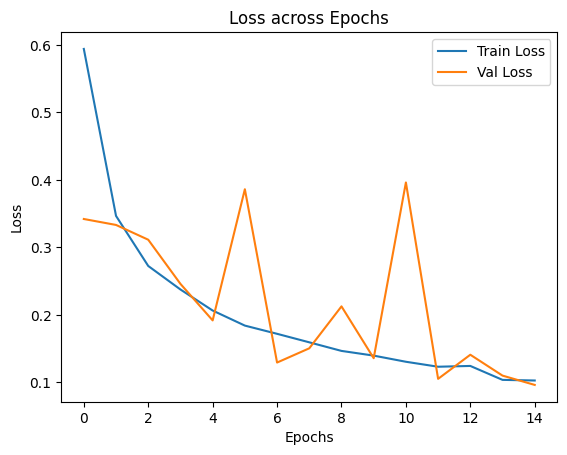

In [15]:
# tcn_model_1 = tcn_classifier(9, [128, 64, 32, 16, 4], True, False)
# tag = f'{dataset_ver}_Causal_128-64-32-16-4'

# print(tcn_model_1)
# train_losses, val_losses = train_TCN(tcn_model_1, tcn_train_dataloader_L, tcn_val_dataloader_L, 1e-3, 15, 5, tag)
# plot_loss_graph(train_losses, val_losses, tag)

In [12]:
tcn_model_test = tcn_classifier(9, [128, 64, 32, 16, 4], True, False)
tag = f'{dataset_ver}_Causal_128-64-32-16-4'

tcn_model_test.load_state_dict(torch.load(f'models/TCN_{tag}.pt'))

<All keys matched successfully>

In [13]:
test_TCN(tcn_model_test, tcn_test_dataloader_L)

  0%|          | 0/3308 [00:00<?, ?it/s]

Train Loss = 0.09392813544645554
Train Acc = 0.9727932285368803
